Everything here is a minor tweak from the lecture on decision trees. Primary motivation is to forecast energy generated using other lagged variables.

# Ensemble Learning
- problem: trees tend to overfit data (i.e., high variance predictors albeit with low bias)
 - Can correct for high variance by using shallow trees (depth 3 to 5).    - But this lacks accuracy, so we should use many different trees and aggregate the results.
   - Bagging (bootstrap aggregation) on the data
     - sample from traning data with replacement
     - combine the data by taking the average (regression) or by voting (class)
     - these can be deep trees
     - potential problem: every tree has the same top node.
     - solution: restrict each tree to a random subset of the predictors. This is called a **random forest**.
   - Boosting: make a tree then fit a tree to the residuals and repeat
       - reduces bias
- how many trees? how deep? how many predictors? All soft questions called **hyperparameters**.
- loss function
- pruning: taking out nodes and refitting?

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz # might need to install -- need *both* python and system
# so use Anaconda (or pip) to install graphviz, and also https://graphviz.org/download/
# this was a non-trivial install on Mac (depends on Xcode command-line tools)
# `pip install graphviz` and `brew install graphviz`
import datetime as dt

%matplotlib inline

# 8.3.1 Fitting Classification Trees

The `sklearn` library has a lot of useful tools for constructing classification and regression trees:

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error, mean_absolute_error

Train/test model on data up to 2017. Will test model on 2018/2019 later.

# TO DO: Import weather data
# TO DO: Break up data into 5-year chunks

**what's a reasonable average**

In [4]:
df = pd.read_csv("../../Data/1999_2021/aggragate_daily_data_2000to2020.csv", index_col = "date").drop(labels = "Unnamed: 0", axis = 1)
df_2017 = df.loc['2000-01-01':'2017-12-31'].copy()
avg = df['energy_generated'].mean()                    #avg is average of energy_generated from 2000 to present
df_2017['high'] = df_2017.energy_generated.map(lambda x: 1 if x > avg else 0) 

Adding 7 day, 14 day, 30 day, 90 day lags to all variables except energy_generated.

In [112]:
df_2017_lagged = df_2017.copy()

for i in [7,14,30]:    #this is so UGLY I wish I knew how to code :(
    df_2017_lagged[['energy_charge_' + str(i)]] = df_2017_lagged.energy_charge.shift(i)
    df_2017_lagged[['influent_flow_' + str(i)]] = df_2017_lagged.influent_flow.shift(i)
    df_2017_lagged[['volume_used_' + str(i)]] = df_2017_lagged.volume_used.shift(i)
    df_2017_lagged[['poured_flow_' + str(i)]] = df_2017_lagged.poured_flow.shift(i)
    df_2017_lagged[['water_level_' + str(i)]] = df_2017_lagged.water_level.shift(i)
    df_2017_lagged[['energy_stored_' + str(i)]] = df_2017_lagged.energy_stored.shift(i)
    df_2017_lagged[['maximum_demand_' + str(i)]] = df_2017_lagged.maximum_demand.shift(i)
    df_2017_lagged[['energy_generated_' + str(i)]] = df_2017_lagged.energy_generated.shift(i)
#    df_2017_lagged[['turbine_flow']] = df_2017_lagged.effluent_flow - df_2017_lagged.poured_flow
#    df_2017_lagged[['turbine_flow_' + str(i)]] = df_2017_lagged.turbine_flow.shift(i)
    df_2017_lagged[['effluent_flow_' + str(i)]] = df_2017_lagged.effluent_flow.shift(i)
    
df_2017_lagged = df_2017_lagged.dropna()


We now use the `DecisionTreeClassifier()` function to fit a classification tree in order to predict
`High`. Unfortunately, manual pruning is not implemented in `sklearn`: http://scikit-learn.org/stable/modules/tree.html

However, we can limit the depth of a tree using the `max_depth` parameter.

**what the heck is a good train size**

Comment: removed current effluent_flow because it's too correlated with energy_generated. If you want to drop a variable from the tree do it here

In [93]:
X = df_2017_lagged.drop(['energy_generated', 'high','effluent_flow','turbine_flow'], axis = 1)
y = df_2017_lagged.high
lst=[]

for k in range(1,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = k*.1, random_state = 0)
    for x in range(1,11):
        classification_tree_daily = DecisionTreeClassifier(max_depth = x)
        classification_tree_daily.fit(X_train, y_train)
        lst.append([x,k,classification_tree_daily.score(X_train, y_train)])


**comment**: Adding all lags on all variables at once makes the training score go down (was previously 0.99 with 30 lag on everything.)

From the resulting lst I arbitrarily chose train_size = 0.1, max_depth = 7

One of the most attractive properties of trees is that they can be
graphically displayed. Unfortunately, this is a bit of a roundabout process in `sklearn`. We use the `export_graphviz()` function to export the tree structure to a temporary `.dot` file,
and the `graphviz.Source()` function to display the image:

In [95]:
df_2017_lagged[['energy_generated','turbine_flow','turbine_flow_7','energy_generated_7']].head(5)

,energy_generated,turbine_flow,turbine_flow_7,energy_generated_7
date,,,,
2000-01-31,1.1966,330.12,381.12,1.3904
2000-02-01,1.1855,329.03,386.12,1.4102
2000-02-02,0.9351,259.03,340.12,1.2346
2000-02-03,0.7949,221.03,283.12,1.0341
2000-02-04,0.8367,224.03,348.12,1.2728


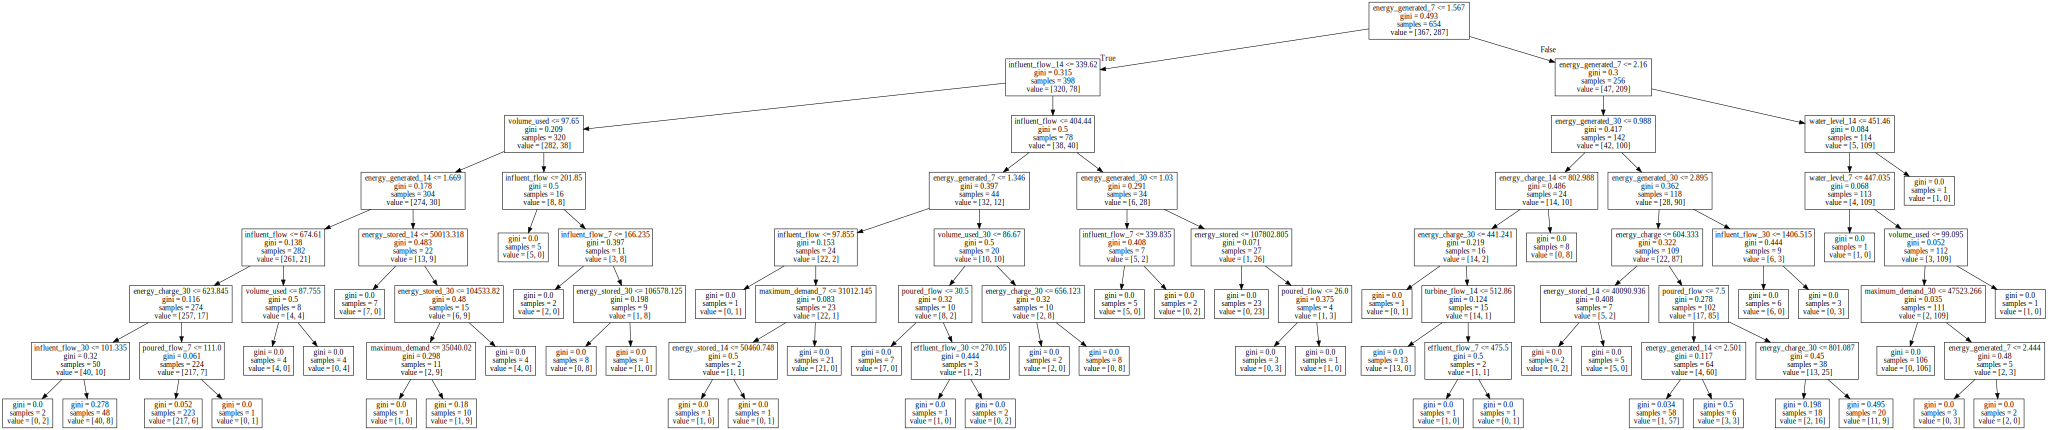

In [96]:
X = df_2017_lagged.drop(['energy_generated','high','effluent_flow','turbine_flow'], axis = 1)
y = df_2017_lagged.high

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = .1, random_state = 0)
classification_tree_daily = DecisionTreeClassifier(max_depth = 7)
classification_tree_daily.fit(X_train, y_train)
export_graphviz(classification_tree_daily, 
                out_file = "tree.dot", 
                feature_names = X_train.columns)

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

Max depth of 6, train_size of 0.8: effluent_flow, effluent_flow_7, influent_flow, effluent_flow_14 were the most important indicators in that order when all lags are included.


Finally, let's evaluate the tree's performance on
the test data. The `predict()` function can be used for this purpose. We can then build a confusion matrix.

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 7*0.1, random_state = 5)
classification_tree_daily = DecisionTreeClassifier(max_depth = 4)
classification_tree_daily.fit(X_train, y_train)

pred = classification_tree_daily.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, 
                  index = ['No', 'Yes'], 
                  columns = ['No', 'Yes'])
print(cm)

      No  Yes
No   864  171
Yes  220  708


# 8.3.2 Fitting Regression Trees

Now let's try fitting a **regression tree**. 

In [113]:
X = df_2017_lagged.drop(['energy_generated','high','effluent_flow'], axis = 1)
y = df_2017_lagged.energy_generated
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

# Pruning not supported. Choosing max depth 2)
regr_tree_daily = DecisionTreeRegressor(max_depth = 2)
regr_tree_daily.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=2)

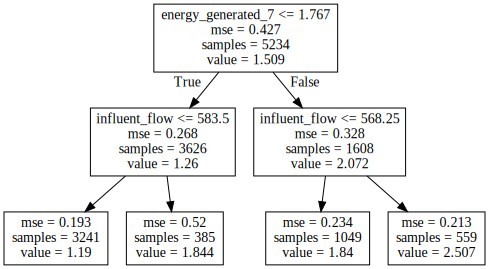

In [114]:
export_graphviz(regr_tree_daily, 
                out_file = "regr_tree.dot", 
                feature_names = X_train.columns)

with open("regr_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

max depth of 2 or 3: effluent_flow, effluent_flow_7,influent_flow,effluent_flow_14

0.3798763850399958

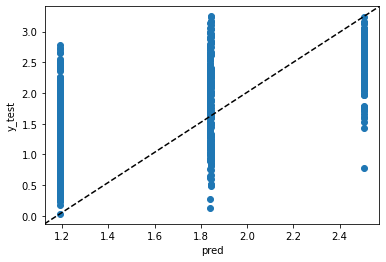

In [108]:
pred = regr_tree_daily.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'medv')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_absolute_error(y_test, pred)

In [109]:
X_train.shape

(5234, 34)

In [115]:
# Bagging: using all features
bagged_daily = RandomForestRegressor(max_features = 33, random_state = 1)
bagged_daily.fit(X_train, y_train)

RandomForestRegressor(max_features=33, random_state=1)

0.24143042042184873

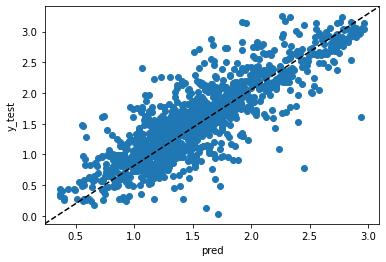

In [116]:
pred = bagged_daily.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'energy_generated')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

mean_absolute_error(y_test, pred)

In [ ]:
'''lst = []

for j in range(1,11):
    for k in range(1,11):
        random_forest_daily = RandomForestRegressor(max_features = k, random_state = j)
        random_forest_daily.fit(X_train, y_train)
        pred = random_forest_daily.predict(X_test)
        Importance = pd.DataFrame({'Importance':random_forest_daily.feature_importances_*100}, 
                          index = X.columns)
        Importance = Importance[Importance['Importance'] > 7]
        lst.append([k, round(mean_squared_error(y_test, pred),5), Importance])

lst'''

turbine_flow_7 is the most important variable (after turbine_flow and effluent_flow). Has a correlation of 0.6814313 with energy_generated. Interesting because it shows that even with a little bit of time lag, we have an ok indicator of what future energy generation will be. 

In [123]:
X = df_2017_lagged.drop(['energy_generated','high','effluent_flow','influent_flow'], axis = 1)
y = df_2017_lagged.energy_generated
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

random_forest_daily = RandomForestRegressor(max_features = 7, random_state = 1)
random_forest_daily.fit(X_train, y_train)
pred = random_forest_daily.predict(X_test)

,Importance
energy_generated_7,18.903648
influent_flow_7,12.460664
effluent_flow_7,8.702090
poured_flow,6.519513
energy_generated_14,5.653713
influent_flow_14,4.160979
effluent_flow_14,3.517085
influent_flow_30,2.317133
water_level,2.276268
volume_used,2.271623


In [145]:
mean_absolute_error(y_test, random_forest_daily.predict(X_test))

0.2430335858106188

In [124]:
Importance = pd.DataFrame({'Importance':random_forest_daily.feature_importances_*100}, 
                          index = X.columns).sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = False)
Importance.head(10)

,Importance
energy_generated_7,18.903648
influent_flow_7,12.460664
effluent_flow_7,8.702090
poured_flow,6.519513
energy_generated_14,5.653713
influent_flow_14,4.160979
effluent_flow_14,3.517085
influent_flow_30,2.317133
water_level,2.276268
volume_used,2.271623


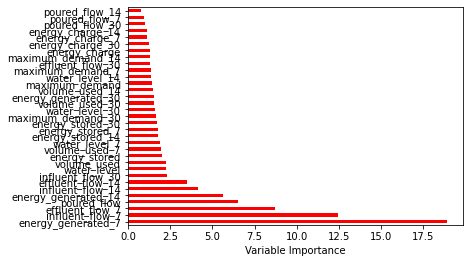

In [125]:
Importance.plot(kind = 'barh', color = 'r', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None

# 8.3.4 Boosting

Now we'll use the `GradientBoostingRegressor` package to fit **boosted
regression trees** to the `Boston` data set. The
argument `n_estimators = 500` indicates that we want 500 trees, and the option
`interaction.depth = 4` limits the depth of each tree:

In [141]:
X = df_2017_lagged.drop(['energy_generated','high','effluent_flow','influent_flow'], axis = 1)
y = df_2017_lagged.energy_generated
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

boosted_daily = GradientBoostingRegressor(n_estimators = 500, 
                                           learning_rate = 0.2, 
                                           max_depth = 4, 
                                           random_state = 1)

boosted_daily.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=4, n_estimators=500,
                          random_state=1)

Let's check out the feature importances again:

In [142]:
feature_importance = boosted_daily.feature_importances_*100

rel_imp = pd.Series(feature_importance, 
                    index = X.columns).sort_values(inplace = False,ascending = False)

In [143]:
rel_imp.head(10)

energy_generated_7     40.727406
influent_flow_7        12.166295
poured_flow             7.071350
energy_stored_30        3.179736
energy_generated_14     2.527498
energy_stored           2.506568
energy_stored_14        2.314368
maximum_demand_30       2.067650
water_level             2.041425
volume_used             1.923378
dtype: float64

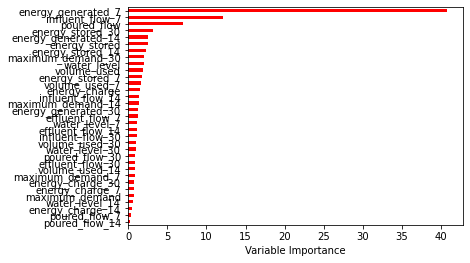

In [130]:
rel_imp.T.plot(kind = 'barh', 
               color = 'r', )

plt.xlabel('Variable Importance')

plt.gca().legend_ = None

We see that `lstat` and `rm` are again the most important variables by far. Now let's use the boosted model to predict `medv` on the test set:

In [144]:
mean_absolute_error(y_test, boosted_daily.predict(X_test))

0.24912439218650823

If we want to, we can perform boosting
with a different value of the shrinkage parameter $\lambda$. Here we take $\lambda = 0.2$:

In [ ]:
boosted_daily2 = GradientBoostingRegressor(n_estimators = 500, 
                                            learning_rate = 0.4, 
                                            max_depth = 4, 
                                            random_state = 1)
boosted_daily2.fit(X_train, y_train)

mean_squared_error(y_test, boosted_daily2.predict(X_test))

In this case, using $\lambda = 0.2$ leads to a slightly lower test MSE than $\lambda = 0.01$.

To get credit for this lab, post your responses to the following questions:
 - What's one real-world scenario where you might try using Bagging?
 - What's one real-world scenario where you might try using Random Forests?
 - What's one real-world scenario where you might try using Boosting?
 
to Moodle: https://moodle.smith.edu/mod/quiz/view.php?id=264671

## Conclusion

Considering lags on all variables of 7, 14, and 30 days, the most important variables are (in order):

1. energy_generated lagged 7 days
2. effluent_flow lagged 7 days
3. influent_flow lagged 7 days
4. energy_generated lagged 14 days
5. effluent_flow lagged 14 days
6. influent_flow lagged 14 days

After that I no longer feel confident about ranking the variables.